In [1]:
from model import *
from optax import adam
from src.datagen import Equations
import os
from jax import jit, vmap, random, lax
import jax
import matplotlib.pyplot as plt
import seaborn as sns
import time
import scienceplots

jax.config.update("jax_enable_x64", True)
plt.style.use("science")

In [2]:
state_variables = 20
expected_number_of_nls = 10
input_dim = state_variables * expected_number_of_nls
output_dim = state_variables

model = ZeroLayersNN(N=input_dim, L=expected_number_of_nls, output_dim=state_variables)
seed = 42
train_batch_size = 32
test_batch_size = 64


dummy_input = jnp.zeros((train_batch_size, input_dim))
key = random.key(seed)
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
print(
    f"There are {count_params(state.params['params'])} learnable parameters in the current architecture."
)

There are 4080 learnable parameters in the current architecture.


In [7]:
def generate_alphabeta(dim, num, spread, seed):
    key = random.key(seed)
    shape = (dim, num)
    A = random.normal(key, shape)
    # Q, _, _ = jnp.linalg.svd(A, full_matrices=True)
    return A * spread


def generate_callable_functions(dim, num, spread, seed):
    bases = generate_alphabeta(dim, num, spread, seed)  # Get num basis vectors
    bases = bases.T
    alphas = bases[:, : dim // 2]  # First half of Q are alphas
    gammas = bases[:, dim // 2 :]

    def make_function(alpha, gamma):
        @jit
        def func(x):
            return (
                alpha[0] * nn.relu(x + gamma[0])
                + alpha[1] * nn.relu(x + gamma[1])
                + alpha[2] * nn.relu(x + gamma[2])
            )

        return func

    return tuple([make_function(alphas[i], gammas[i]) for i in range(num)]), bases

In [8]:
dims = 6
n_nls = 10
spread = 5
alphagamma = generate_alphabeta(dims, n_nls, spread, seed)
alphagamma = alphagamma.T
alphas = alphagamma[:, : dims // 2].T  # First half of Q are alphas
gammas = alphagamma[:, dims // 2 :].T
print(alphagamma.shape)
print("Alphas:", alphas)
print("Gammas:", gammas)

non_lins, vec_nls = generate_callable_functions(dims, n_nls, spread, seed)

config = {
    "n_vars": state_variables,
    "n_eqs": state_variables,
    "bounds_addends": (1, 3),
    "bounds_multiplicands": (1, 1),
    "non_lins": non_lins,
    "sym_non_lins": None,
    "distribution": "uniform",
    "a": None,
    "b": None,
    "sigma": None,
    "p": None,
    "seed": seed,
}

(10, 6)
Alphas: [[-2.17664396e+00 -1.23063727e+00 -9.10063268e-02 -1.00054252e+01
   4.36819991e+00  6.63121219e+00  5.41533972e+00 -5.41601000e+00
  -1.18614539e+00  1.87047068e-01]
 [-6.29406871e+00  8.39689247e+00 -2.85060975e-01 -9.11655876e-03
   3.32054825e+00 -3.01020399e+00  4.89783329e+00 -7.14198085e+00
   3.99605577e+00  2.75162241e-01]
 [-5.19491848e+00  3.82128144e+00 -6.88120963e+00 -1.46862708e+00
  -2.63901110e-01  9.54288332e+00  7.23484906e-01 -5.05650263e+00
   1.88592948e+00 -1.03215941e+00]]
Gammas: [[ 3.93060866  4.3068647   1.10358323  5.71528543 -6.0367638   2.13592935
  -6.3757238  -3.1713859   2.76504282 -6.01914822]
 [ 7.0637436   1.51231557  8.86721081 -5.84395951  4.64757295 -3.90751904
  -4.16169437 -8.23583881  1.04654252  0.83512535]
 [-4.58035497  7.24401073  2.59579719  4.20033569  1.70315899 -0.52488645
  -0.97483095 -5.1379733  -1.91848673  2.30577237]]


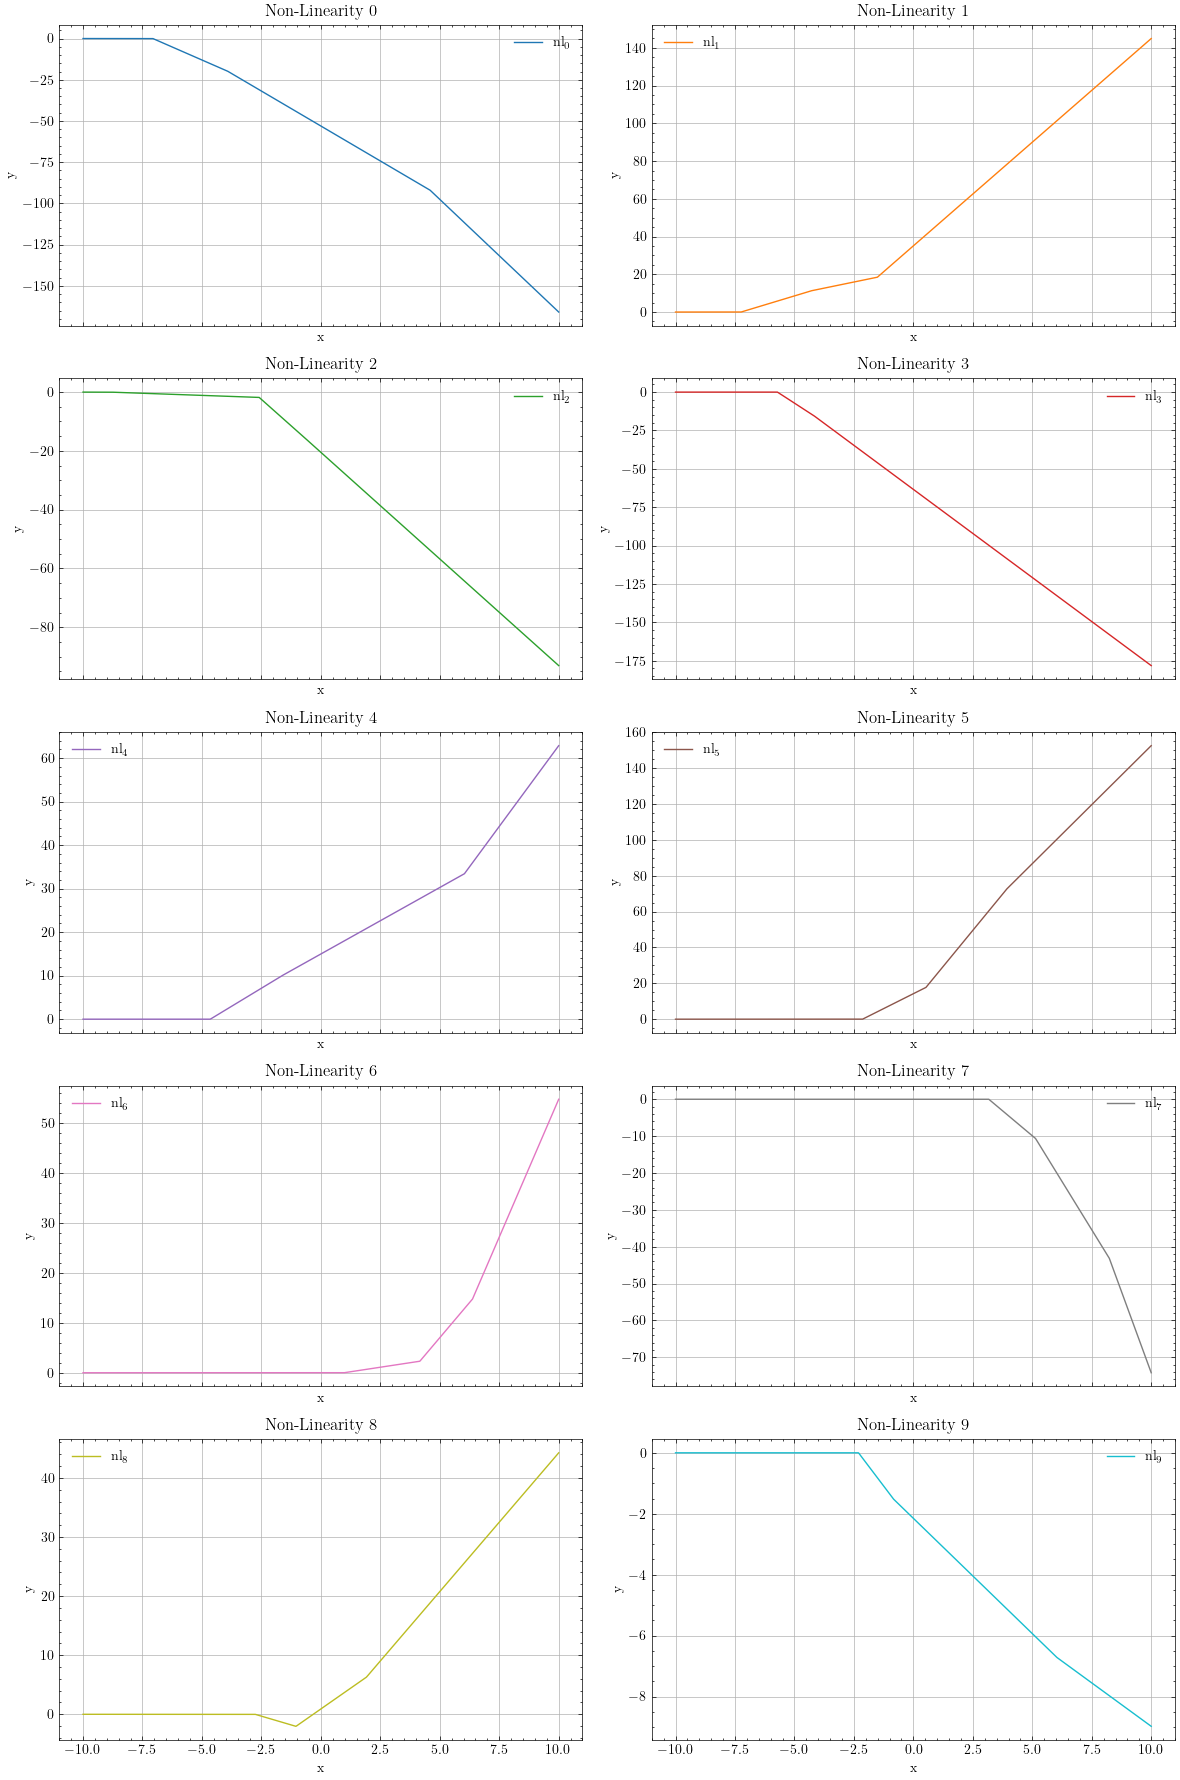

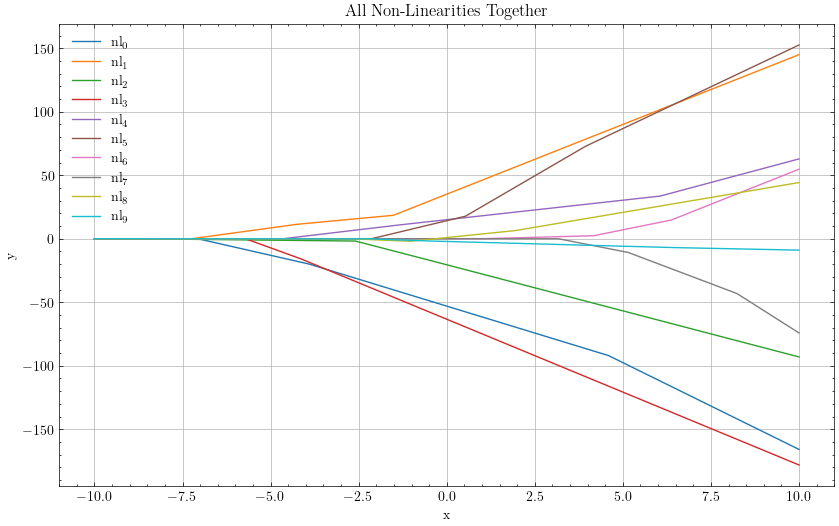

In [9]:
# Create subplots for individual non-linearities
num_funcs = len(non_lins)
cols = 2  # Number of columns in the grid
rows = (num_funcs + 1) // cols  # Rows for individual plots
fig, axes = plt.subplots(rows, cols, figsize=(12, 18), sharex=True)

x = jnp.linspace(-10, 10, 1000)
colors = plt.cm.tab10(range(num_funcs))  # Use a colormap to assign colors

# Plot each callable's result in separate subplots
for i, func in enumerate(non_lins):
    row, col = divmod(i, cols)
    ax = axes[row, col]
    y = func(x)
    ax.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Non-Linearity {i}")
    ax.legend()
    ax.grid(True)

# Adjust layout for individual plots
plt.tight_layout()
plt.show()
plt.clf()
plt.close()

# Create a separate figure for all non-linearities together
plt.figure(figsize=(10, 6))
for i, func in enumerate(non_lins):
    y = func(x)
    plt.plot(x, y, label=r"$\text{nl}_{%d}$" % i, color=colors[i])
plt.xlabel("x")
plt.ylabel("y")
plt.title("All Non-Linearities Together")
plt.legend()
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [10]:
system = Equations(config)
system.save_symb_expr()

System and state loaded from equations_e26c00536e47a0085401091c2793c3ea.pkl
PDF already exists


In [11]:
def my_eval(v):
    return system(y=v)

In [12]:
bound = 15
train_size = int(1e4)
test_ratio = 0.2
test_size = int(test_ratio * train_size)
total_size = train_size + test_size
train_values = jnp.tile(
    jnp.linspace(-1 * bound, bound, total_size).reshape(-1, 1), (1, config["n_eqs"])
)

# Randomly select `test_size` elements for inbound_test
key = random.key(seed)
key, subkey = random.split(key)  # Ensure reproducibility
indices = random.choice(
    subkey, total_size, shape=(test_size,), replace=False
)  # Unique indices
inbound_test = train_values[indices]  # Extract test points
mask = jnp.ones(total_size, dtype=bool)
mask = mask.at[indices].set(False)  # Mask out test points
train_values = train_values[mask]  # Remove test points from training set

# Create out-of-bound test values
range1 = jnp.linspace(-1 * bound - 5, -1 * bound, test_size // 2)
range2 = jnp.linspace(bound, bound + 5, test_size // 2)
outofbound_test = jnp.concatenate((range1, range2), axis=0).reshape(-1, 1)
outofbound_test = jnp.tile(outofbound_test, (1, config["n_eqs"]))

# Stack both test sets
stacked_test = jnp.vstack((inbound_test, outofbound_test))

# Concatenate train and test values
values = jnp.vstack((train_values, stacked_test))

# Standardize values
values_mean = jnp.mean(values, axis=0)
values_std = jnp.std(values, axis=0)


# Evaluate
evaluated_values = vmap(my_eval)(values)
values = (values - values_mean) / values_std

# Standardize evaluated_values
evaluated_values_mean = jnp.mean(evaluated_values, axis=0)
evaluated_values_std = jnp.std(evaluated_values, axis=0)
evaluated_values = (evaluated_values - evaluated_values_mean) / evaluated_values_std

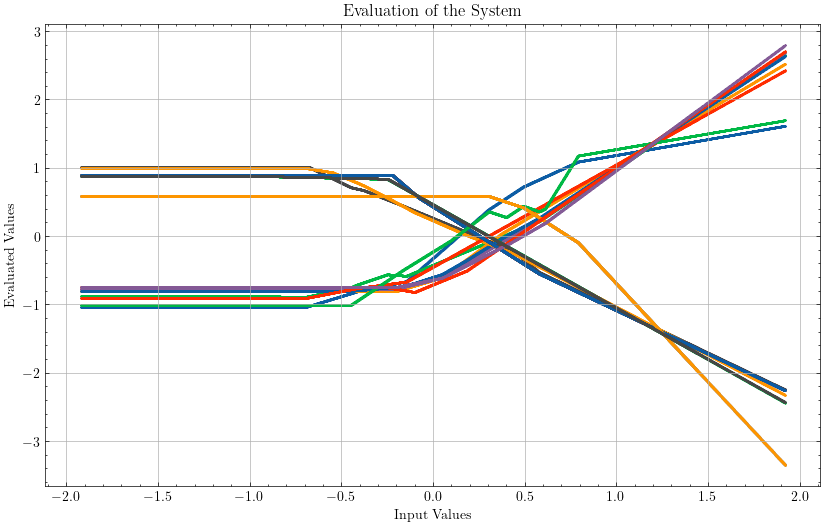

In [13]:
plt.figure(figsize=(10, 6))
for i in range(config["n_eqs"]):
    plt.scatter(values[:, 0], evaluated_values[:, i], label=f"Equation {i+1}", s=0.1)
plt.xlabel("Input Values")
plt.ylabel("Evaluated Values")
plt.title("Evaluation of the System")
plt.grid(True)
plt.show()
plt.clf()
plt.close()

In [14]:
expanded_values = jnp.repeat(values, expected_number_of_nls, axis=1)
train_values = expanded_values[:train_size]
inbound_test = expanded_values[train_size : test_size + train_size]
outofbound_test = expanded_values[test_size + train_size :]

train_outputs, inbound_test_outputs = (
    evaluated_values[:train_size],
    evaluated_values[train_size : test_size + train_size],
)
outofbound_test_outputs = evaluated_values[test_size + train_size :]

train_batches = create_batches(train_values, train_outputs, train_batch_size)
inbound_test_batches = create_batches(
    inbound_test, inbound_test_outputs, test_batch_size
)
outofbound_test_batches = create_batches(
    outofbound_test, outofbound_test_outputs, test_batch_size
)

In [15]:
vectors = jnp.concatenate(
    (
        state.params["params"]["CustomActivation_0"]["alpha"],
        state.params["params"]["CustomActivation_0"]["gamma"],
    ),
    axis=0,
).T
print(vectors)

[[ 0.00532239  0.00714493 -0.0140789   0.00454999 -0.02293794  0.00683664]
 [ 0.00794285 -0.01769428 -0.00338034 -0.00961454  0.01148725  0.00307049]
 [-0.01265172  0.00461983  0.00353754  0.00966763  0.00562015 -0.00740278]
 [-0.0088373   0.0148007  -0.00397315  0.00386923  0.00092771  0.00438353]
 [-0.00451383  0.00588339  0.00458301 -0.01107864 -0.00707142  0.01236508]
 [-0.00118079  0.00710852 -0.0010772   0.01157445  0.00603831  0.02277317]
 [ 0.00876648 -0.00210951 -0.01823763 -0.01055286  0.00146548  0.01059086]
 [ 0.00378797 -0.00902386 -0.00049722 -0.00341193 -0.00089004 -0.00102033]
 [ 0.00209711  0.01537324 -0.0033344  -0.01749108  0.01873896 -0.01112696]
 [-0.00213164  0.00031909  0.00519398  0.00799576 -0.01001314  0.00642764]]


In [ ]:
@partial(jax.jit, static_argnums=(1))
def loss_fn(params, apply_fn, batch_x, batch_y, l1_lambda=0.01):
    predictions = apply_fn(params, batch_x)
    return jnp.mean((predictions - batch_y) ** 2)


@partial(jax.jit, static_argnums=(1))
def loss_fn(params, apply_fn, batch_x, batch_y, vec_lambda=0.01):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    # Extract alpha and gamma from CustomActivation_0
    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    # Compute L2 distance to target vector
    vec_diff = (alpha - alphas) + (gamma - gammas)
    vec_loss = jnp.sum(vec_diff**2)  # Sum of squared differences

    return mse_loss + vec_lambda * vec_loss

In [30]:
def make_training_functions(loss_fn):
    @jit
    def train_epoch(carry, epoch):
        state, _ = carry  # Unpack state and dummy loss accumulator
        epoch_loss = jnp.array(0.0)

        # Loop over batches
        def batch_step(carry, batch):
            state, _ = carry
            batch_x, batch_y = batch
            state, train_loss = train_step(state, batch_x, batch_y, loss_fn)
            inbound_test_loss = evaluate(state, inbound_test_batches, loss_fn)
            outofbound_test_loss = evaluate(state, outofbound_test_batches, loss_fn)

            return (state, train_loss), (
                train_loss,
                inbound_test_loss,
                outofbound_test_loss,
            )

        (state, _), (
            train_losses,
            inbound_test_losses,
            outofbound_test_losses,
        ) = lax.scan(batch_step, (state, 0.0), train_batches)

        # Print every n epochs
        print_condition = epoch % 5 == 0
        jax.lax.cond(
            print_condition,
            # True branch: print metrics
            lambda: jax.debug.print(
                "Epoch: {epoch}, Train Loss: {train_loss:.4e}, Inbound-Test Loss: {inbound_test_loss:.4e}, Outofbound-Test Loss: {outofbound_test_loss:.4e} ",
                epoch=epoch,
                train_loss=jnp.mean(train_losses),
                inbound_test_loss=jnp.mean(inbound_test_losses),
                outofbound_test_loss=jnp.mean(outofbound_test_losses),
            ),
            # False branch: do nothing
            lambda: None,
        )
        return (state, epoch_loss), (
            train_losses,
            inbound_test_losses,
            outofbound_test_losses,
        )

    return train_step, evaluate, train_epoch

In [ ]:
@partial(jax.jit, static_argnums=(1))
def loss_fn(params, apply_fn, batch_x, batch_y, vec_lambda=0.01):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    # Extract alpha and gamma from CustomActivation_0
    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    # Compute L2 distance to target vector
    vec_diff = (alpha - alphas) + (gamma - gammas)
    vec_loss = jnp.sum(vec_diff**2)  # Sum of squared differences

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1,))
def loss_fn1(params, apply_fn, batch_x, batch_y, vec_lambda=0.01, alpha_hyper=1.0):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    distances = (alpha - alphas) ** 2 + (gamma - gammas) ** 2
    sum_exp = jnp.sum(jnp.exp(-alpha_hyper * distances))
    vec_loss = (1.0 / alpha_hyper) * jnp.log(1 + sum_exp)

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1,))
def loss_fn2(params, apply_fn, batch_x, batch_y, vec_lambda=0.01, sigma=1.0):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    distances = (alpha - alphas) ** 2 + (gamma - gammas) ** 2
    sum_gauss = jnp.sum(jnp.exp(-distances / (2 * sigma**2))) / 3.0
    vec_loss = jnp.log(1 + sum_gauss)

    return mse_loss + vec_lambda * vec_loss


@partial(jax.jit, static_argnums=(1))
def loss_fn3(params, apply_fn, batch_x, batch_y, vec_lambda=0.01):
    predictions = apply_fn(params, batch_x)
    mse_loss = jnp.mean((predictions - batch_y) ** 2)

    # Extract alpha and gamma from CustomActivation_0
    alpha = params["params"]["CustomActivation_0"]["alpha"]
    gamma = params["params"]["CustomActivation_0"]["gamma"]

    # Compute L2 distance to target vector
    vec_diff = (alpha - alphas) + (gamma - gammas)
    vec_loss = jnp.prod(vec_diff**2)  # Product of squared differences

    return mse_loss + vec_lambda * vec_loss

In [ ]:
alpha = params["params"]["CustomActivation_0"]["alpha"]
gamma = params["params"]["CustomActivation_0"]["gamma"]
vec_diff = (alpha - alphas) + (gamma - gammas)
vec_loss = jnp.prod(vec_diff**2)

In [70]:
train_step, evaluate, train_epoch = make_training_functions(loss_fn3)

In [71]:
key, subkey = random.split(key)
params = model.init(subkey, dummy_input)
optimizer = adam(learning_rate=0.001)
state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

In [72]:
num_epochs = 11

(state, loss), (train_losses, inbound_test_losses, outofbound_test_losses) = lax.scan(
    train_epoch, (state, 0.0), jnp.arange(num_epochs)
)
jax.block_until_ready(state)
print("Training complete!")

Epoch: 0, Train Loss: 6.5850e+22, Inbound-Test Loss: 8.8043e+23, Outofbound-Test Loss: 8.8043e+23 
Epoch: 5, Train Loss: 1.0019e-03, Inbound-Test Loss: 1.5161e-02, Outofbound-Test Loss: 6.9235e-02 
Epoch: 10, Train Loss: 8.6434e-04, Inbound-Test Loss: 1.3015e-02, Outofbound-Test Loss: 6.1392e-02 
Training complete!
